In [1]:
DATA_PATH = "data/somascan_171_vs_1305.tsv"
N_GROUPS = 4

# Импорт библиотек

In [2]:
import seaborn as sns
from tqdm.notebook import tqdm
from collections import defaultdict
import pandas as pd
import re
from scipy.stats.stats import pearsonr
import numpy as np
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt
import altair as alt
from itertools import repeat

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Предобработка данных

## Загрузка

In [3]:
df = pd.read_csv(DATA_PATH, sep="\t")

In [4]:
df

,ID,Age,Sex,Cohort,A2M,ABL1,ABL2,ACAN,ACE2,ACP1,...,XPNPEP1,XRCC6,YES1,YWHAB,YWHAB.YWHAE.YWHAG.YWHAH.YWHAQ.YWHAZ.SFN,YWHAE,YWHAQ,YWHAZ,ZAP70,ZNRF3
0,11010,107,Female,PRIN09,"4,056","2,198","2,955","2,79","2,475","3,628",...,"4,157","2,465","2,835","4,28","3,448","3,171","2,959","5,095","3,688","2,52"
1,11030,105,Male,PRIN09,"3,957","2,25","3,036","2,708","2,469","3,697",...,"4,086","2,344","2,924","4,416","3,636","3,146","3,023","5,15","3,68","2,485"
2,11130,106,Female,PRIN09,"4,149","2,199","3,022","2,598","2,508","3,377",...,"4,045","2,172","2,735","4,315","3,389","3,149","3,089","5,133","3,599","2,605"
3,11140,106,Male,PRIN09,"4,066","2,262","3,131","2,704","3,019","3,517",...,"3,6","2,258","2,692","4,084","3,097","3,133","2,968","4,75","3,747","2,556"
4,11150,105,Male,PRIN09,"4,058","2,481","2,99","2,614","2,389","3,04",...,"3,875","2,1","2,732","4,172","3,433","2,986","3,605","5,069","3,707","2,564"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,67,81,Female,Seattle,"4,218","2,223","3,092","2,517","2,488","3,728",...,"4,003","2,09","2,787","4,458","3,529","3,079","3,003","5,184","3,67","2,589"
167,68,87,Male,Seattle,"4,153","2,421","3,077","2,593","2,497","3,093",...,"3,854","2,152","2,685","4,174","3,263","3,097","2,91","5,096","3,721","2,529"
168,69,78,Male,Seattle,"3,922","2,215","3,034","2,575","2,515","3,241",...,"3,927","2,129","2,837","4,453","3,523","3,018","2,952","5,27","3,646","2,777"
169,70,80,Male,Seattle,"4,076","2,207","2,957","2,692","2,457","3,715",...,"3,991","2,163","2,764","4,271","3,407","3,136","2,873","5,148","3,721","2,482"


In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 1309 columns):
 #     Column                                   Dtype 
---    ------                                   ----- 
 0     ID                                       int64 
 1     Age                                      int64 
 2     Sex                                      object
 3     Cohort                                   object
 4     A2M                                      object
 5     ABL1                                     object
 6     ABL2                                     object
 7     ACAN                                     object
 8     ACE2                                     object
 9     ACP1                                     object
 10    ACP5                                     object
 11    ACVR1B                                   object
 12    ACVRL1                                   object
 13    ACY1                                     object
 14    ADAM12

## Предобработка

В данных вещественные числа представлены с запятой в качестве разделителя, 
а python подрозумевает, что разделитель должен быть точкой. Необходимо это исправить

In [6]:
def isfloat(value):
    """
    Проверка на соответствие строки вещественному числу.
    Source: https://stackoverflow.com/a/20929881 
    """
    try:
        float(value)
        return True
    except ValueError:
        return False

In [7]:
def fix_float(x):
    number_regex = r"(\d+),(\d+)"
    to_point_number_regex = r"\1.\2"
    if isinstance(x, str):
        return re.sub(
            number_regex, 
            to_point_number_regex, 
            x
        )
    else:
        return x

In [8]:
df = df.applymap(fix_float)
for column in df.columns:
    if isfloat(df.loc[0, column]) and column not in ["ID", "Age"]:
        df[column] = pd.to_numeric(df[column], downcast="float")

In [9]:
df

,ID,Age,Sex,Cohort,A2M,ABL1,ABL2,ACAN,ACE2,ACP1,...,XPNPEP1,XRCC6,YES1,YWHAB,YWHAB.YWHAE.YWHAG.YWHAH.YWHAQ.YWHAZ.SFN,YWHAE,YWHAQ,YWHAZ,ZAP70,ZNRF3
0,11010,107,Female,PRIN09,4.056,2.198,2.955,2.790,2.475,3.628,...,4.157,2.465,2.835,4.280,3.448,3.171,2.959,5.095,3.688,2.520
1,11030,105,Male,PRIN09,3.957,2.250,3.036,2.708,2.469,3.697,...,4.086,2.344,2.924,4.416,3.636,3.146,3.023,5.150,3.680,2.485
2,11130,106,Female,PRIN09,4.149,2.199,3.022,2.598,2.508,3.377,...,4.045,2.172,2.735,4.315,3.389,3.149,3.089,5.133,3.599,2.605
3,11140,106,Male,PRIN09,4.066,2.262,3.131,2.704,3.019,3.517,...,3.600,2.258,2.692,4.084,3.097,3.133,2.968,4.750,3.747,2.556
4,11150,105,Male,PRIN09,4.058,2.481,2.990,2.614,2.389,3.040,...,3.875,2.100,2.732,4.172,3.433,2.986,3.605,5.069,3.707,2.564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,67,81,Female,Seattle,4.218,2.223,3.092,2.517,2.488,3.728,...,4.003,2.090,2.787,4.458,3.529,3.079,3.003,5.184,3.670,2.589
167,68,87,Male,Seattle,4.153,2.421,3.077,2.593,2.497,3.093,...,3.854,2.152,2.685,4.174,3.263,3.097,2.910,5.096,3.721,2.529
168,69,78,Male,Seattle,3.922,2.215,3.034,2.575,2.515,3.241,...,3.927,2.129,2.837,4.453,3.523,3.018,2.952,5.270,3.646,2.777
169,70,80,Male,Seattle,4.076,2.207,2.957,2.692,2.457,3.715,...,3.991,2.163,2.764,4.271,3.407,3.136,2.873,5.148,3.721,2.482


Получим все float колонки (без Age).

In [10]:
num_columns = df.select_dtypes(include=[np.float32, np.int64]).drop(["ID", "Age"], axis=1).columns
num_columns

Index(['A2M', 'ABL1', 'ABL2', 'ACAN', 'ACE2', 'ACP1', 'ACP5', 'ACVR1B',
       'ACVRL1', 'ACY1',
       ...
       'XPNPEP1', 'XRCC6', 'YES1', 'YWHAB',
       'YWHAB.YWHAE.YWHAG.YWHAH.YWHAQ.YWHAZ.SFN', 'YWHAE', 'YWHAQ', 'YWHAZ',
       'ZAP70', 'ZNRF3'],
      dtype='object', length=1305)

# Определить 5 показателей, которые сильнее всего изменяются в процессе старения

Расчитаем матрицу корреляции всех численых колонок.

In [11]:
corr_with_age = df.drop(
    ["ID", "Age"], axis=1
).corrwith(
    df["Age"]
)
corr_with_age

A2M     -0.175110
ABL1     0.046164
ABL2     0.251220
ACAN    -0.025659
ACE2     0.263289
           ...   
YWHAE   -0.273916
YWHAQ    0.170862
YWHAZ   -0.088148
ZAP70    0.047161
ZNRF3    0.055326
Length: 1305, dtype: float64

Выберем солонки с наибольшей корреляцией по модулю.

In [12]:
best_age_corr = corr_with_age.abs().sort_values(ascending=False)[:5].index

In [13]:
print("Показатели которые сильнее всего изменяются в процессе старения (с p-value)")
for col in best_age_corr:
    print(f"{col}\t{corr_with_age[col]}")

Показатели которые сильнее всего изменяются в процессе старения (с p-value)
GDF15	0.8325344921226059
PTN	0.817282920206102
CCDC80	0.7965374286614524
EFEMP1	0.7782000221423817
MMP12	0.7641305137816954


Графически отобразим зависимость полученых колонок от возраста.

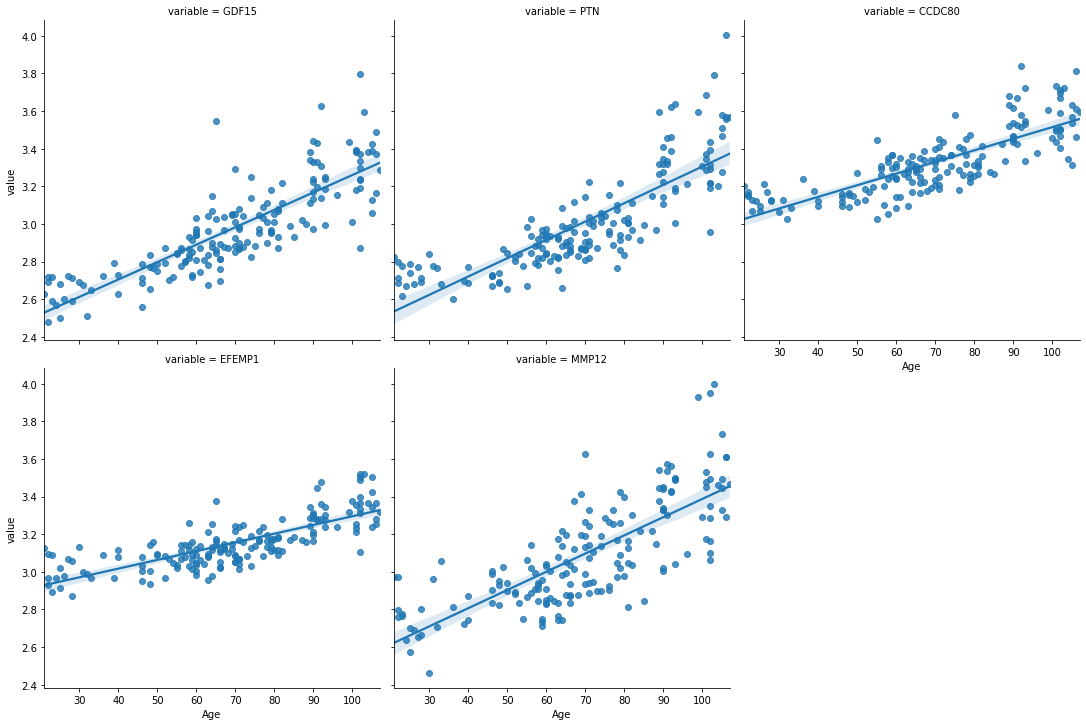

In [14]:
melt_df = pd.melt(df, id_vars=['Age'], value_vars=best_age_corr)
sns.lmplot(x="Age", y="value", col="variable", data=melt_df, col_wrap=3)

# Cтатистическая проверку равенства средних значений между выборками диапазонов

## Разделение данных на группы по возрасту

In [15]:
binds = np.linspace(
    min(df["Age"])-1,
    max(df["Age"]),
    num = N_GROUPS + 1
)
df["Group"] = pd.cut(x=df['Age'], bins=binds, labels=range(N_GROUPS))

In [16]:
print("Даныне разделены на следующие групы:")
for i in range(N_GROUPS):
    in_group_count = df.loc[df["Group"] == i, "Age"].size
    print(f"{i}. {binds[i]:.2f} < Age <= {binds[i+1]:.2f}; Элементов - {in_group_count} ")

Даныне разделены на следующие групы:
0. 20.00 < Age <= 41.75; Элементов - 21 
1. 41.75 < Age <= 63.50; Элементов - 43 
2. 63.50 < Age <= 85.25; Элементов - 60 
3. 85.25 < Age <= 107.00; Элементов - 47 


## Cтатистическая проверка равенства средних значений между выборками диапазонов

Проводим t-test Стьюдента по всем показателям между всеми парами групп.

In [17]:
ttests = defaultdict(dict)
for group1 in tqdm(range(N_GROUPS)):
    for group2 in range(group1+1, N_GROUPS):
        for col in num_columns:
            test = ttest_ind(
                (df.loc[df["Group"] == group1, col]).to_numpy(),
                (df.loc[df["Group"] == group2, col]).to_numpy()
            )
            ttests[(group1, group2)][col] = {
                "statistic": test.statistic,
                "pvalue": test.pvalue
            }

  0%|          | 0/4 [00:00<?, ?it/s]

## Результаты для наиболее зависимых от возраста показателей

In [18]:
heatMatrixs = {}
for col in num_columns:
    statisticMatrix = np.zeros((N_GROUPS, N_GROUPS))
    pvalueMatrix = np.ones((N_GROUPS, N_GROUPS))
    for (group1, group2), value in ttests.items():
        statisticMatrix [group1, group2] = value[col]["statistic"] 
        statisticMatrix [group2, group1] = value[col]["statistic"] 
        pvalueMatrix[group1, group2] = value[col]["pvalue"] 
        pvalueMatrix[group2, group1] = value[col]["pvalue"] 
    heatMatrixs[col] = {
        "statistic": statisticMatrix,
        "pvalue": pvalueMatrix
    }

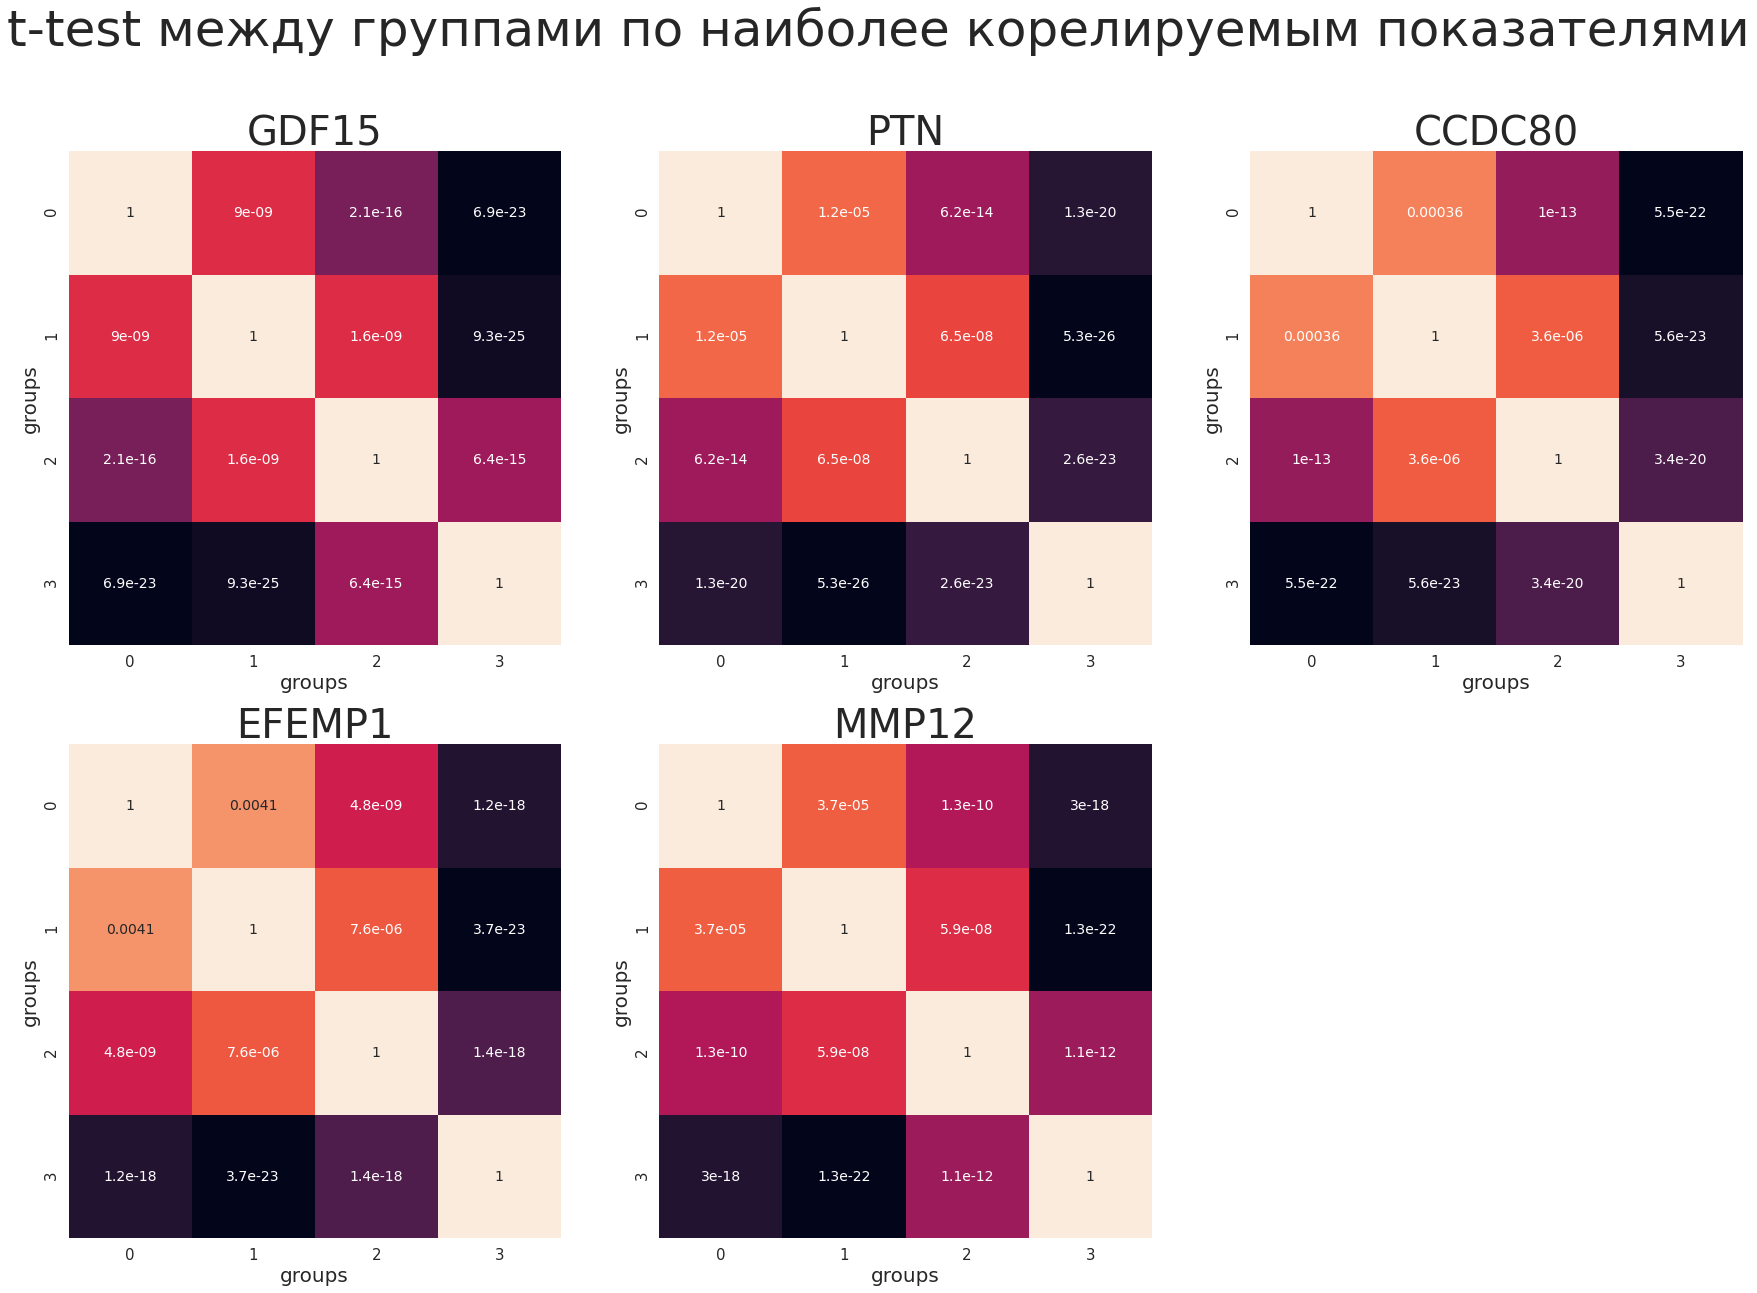

In [19]:
sns.set(rc={'figure.figsize':(30, 20), "font.size":14})
fig, axes = plt.subplots(2, 3)
fig.delaxes(axes.flatten()[-1])
fig.suptitle('t-test между группами по наиболее корелируемым показателями', fontsize=50)

for col, ax in zip(best_age_corr, axes.flatten()):
    p = sns.heatmap(
        heatMatrixs[col]["statistic"], 
        ax = ax,
        annot = heatMatrixs[col]["pvalue"], 
        label = col,
        cbar = False
    );
    p.axes.set_title(col, fontsize=40)
    p.set_xlabel("groups",fontsize=20)
    p.set_ylabel("groups",fontsize=20)
    p.tick_params(labelsize=15)

## Результы между группами по выбраным показателям

Отображается heatmap для различных показателей. Показатель можно выбрать
из списка под графиком. Для отображения возможно необходимо перезапустить код.

In [20]:
heatFeatures = defaultdict(list)
for col in num_columns:
    x, y = np.meshgrid(range(N_GROUPS), range(N_GROUPS))
    statistic = heatMatrixs[col]["statistic"]
    pvalue = heatMatrixs[col]["pvalue"]
    heatFeatures["x"].extend(x.ravel())
    heatFeatures["y"].extend(y.ravel())
    heatFeatures["statistic"].extend(statistic.ravel())
    heatFeatures["pvalue"].extend(pvalue.ravel())
    heatFeatures["feature"].extend(
        repeat(
            col,
            len(x.ravel())
        )
    )
heatFeatures = pd.DataFrame(heatFeatures)

In [21]:
feature_bind = alt.binding_select(options=list(num_columns))
features_select = alt.selection(
    type='single',
    fields=["feature"],
    bind=feature_bind,
    name="Features ",
    init = {
        'feature': num_columns[0]
    }
)

heatmap_base = alt.Chart(heatFeatures).encode(
    alt.X('x:O', axis=alt.Axis(title="group")),
    alt.Y('y:O', axis=alt.Axis(title="group")),
).properties(
    width=500,
    height=500,
    title='Heatmap'
).transform_filter(
    features_select
)

heatmap = heatmap_base.mark_rect().encode(
    color=alt.Color('statistic:Q', legend=None)
)

heatmap_text = heatmap_base.mark_text(align='center', dx=0, dy=0).encode(
    text=alt.Text('pvalue:Q', format = '.3e')
)

(heatmap + heatmap_text).add_selection(
    features_select
)

alt.LayerChart(...)

## p-value для всех показателей по группам

Отображается scutter plot для пары групп и всех показателей отсортированных
по возрастанию p-value. Пару сравниваемых групп можно выбрать
из списка под графиком. Изначально показано первые 50 показателей,
но можно просматривать другие области диапозона или увеличивать дипапазон 
посредствам нижней панели.
Для отображения возможно необходимо перезапустить код.

In [24]:
df = defaultdict(list)
for group, value in ttests.items():
    features = np.array(list(value.keys()))
    pvalues = np.array([x["pvalue"] for x in value.values()])
    order = sorted(
        range(len(features)),
        key = lambda i: pvalues[i]
    )
    df["order_in_group"].extend(
        range(len(features))
    )
    df["group"].extend(
        repeat(f"group {group[0]} vs group {group[1]}", len(features))
    )
    df["pvalue"].extend(
        pvalues[order]
    )
    df["feature"].extend(
        features[order]
    )
df = pd.DataFrame(df)

In [25]:
group_bind = alt.binding_select(options=list(set(df["group"])))
groups = alt.selection(
    type='single',
    fields=["group"],
    bind=group_bind,
    name="Groups",
    init = {
        'group': "group 0 vs group 1"
    }
)

brush = alt.selection(
    type='interval', 
    encodings=['x'],
    init={
        'x': [0, 50]
    }
)
nearest = alt.selection(
    type='single', 
    nearest=True, 
    on='mouseover',
    encodings=['x'],
    empty='none'
)

base = alt.Chart(df).mark_circle(
    size = 50
).properties(
    width=800,
    height=400
).transform_filter(
    groups
)

upperBase = base.encode(
    x = alt.X(
        'feature', 
        axis=alt.Axis(
            labelAngle=-90, 
            labels=True, 
            title="Feature", 
            minExtent = 200
        ),
        sort=alt.SortField(field='pvalue')
    ),
).transform_filter(
    brush
)

upper = upperBase.encode(
    y = alt.Y(
        'pvalue', 
        axis=alt.Axis(
            title="P-Value", 
            format='.2e'
        )
    ),
    color = alt.condition(
        nearest, 
        alt.value("red"), 
        alt.value("#0193ca")
    )
).add_selection(
    nearest
)

rules = upperBase.mark_rule(color='red').transform_filter(
    nearest
)

text = upperBase.mark_text(align='right', dx=-8, dy=-15).encode(
    y='pvalue',
    text=alt.condition(nearest, 'pvalue', alt.value(''), format='.2e')
)

lower = base.mark_line().encode(
    x = alt.X('order_in_group', axis=alt.Axis(labels=False, title="")),
    y = alt.Y('pvalue', axis=alt.Axis(labels=False, title=""))
).properties(
    height=60
).transform_filter(
    groups
).add_selection(
    groups,
    brush
)


upper + rules + text & lower

alt.VConcatChart(...)